# Time series prediction with neural networks.

The problem we are going to look at in this post is the international airline passengers prediction problem.

This is a problem where given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960 or 12 years, with 144 observations.

In [2]:
import keras 
print('keras:', keras.__version__)

('keras:', '1.1.2')


In [3]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)

import numpy
import matplotlib.pyplot as plt
import pandas
import math
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('files/international-airline-passengers.csv', 
                            usecols=[1], 
                            engine='python', 
                            skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX[0], trainY[0])


# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=0)

(96, 48)
(array([ 112.], dtype=float32), 118.0)


In [4]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(abs(dataset-testPredictPlot))
plt.show()

import math
print "The average error on the training dataset was {:.0f} passengers\
(in thousands per month) and the average error on the unseen\
test set was {:.0f} passengers (in thousands per month).".format(math.sqrt(trainScore) \
                                                                  ,math.sqrt(testScore))

Train Score: 529.35 MSE (23.01 RMSE)
Test Score: 2350.24 MSE (48.48 RMSE)


The average error on the training dataset was 23 passengers(in thousands per month) and the average error on the unseentest set was 48 passengers (in thousands per month).


## The Window Method

We can also phrase the problem so that multiple recent time steps can be used to make the prediction for the next time step.

This is called the window method, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time ($t$) we want to predict the value at the next time in the sequence ($t + 1$), we can use the current time ($t$) as well as the two prior times ($t-1$ and $t-2$).

When phrased as a regression problem the input variables are $t-2$, $t-1$, $t$ and the output variable is $t+1$.

In [5]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t, t-1, t-2)
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('files/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX[0], trainY[0])

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=20, verbose=0)

(96, 48)
(array([ 112.,  118.,  132.], dtype=float32), 129.0)


Train Score: 1265.59 MSE (35.58 RMSE)
Test Score: 6283.64 MSE (79.27 RMSE)


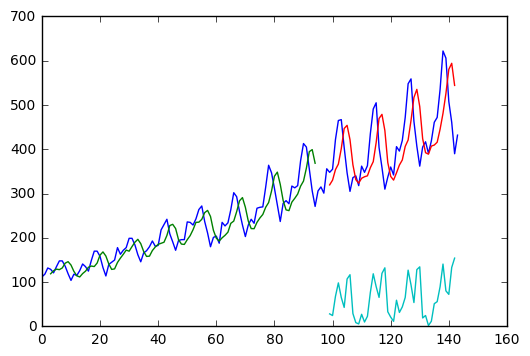

The average error on the training dataset was 36 passengers (in thousands per month) and the average error on the unseen test set was 79 passengers (in thousands per month).


In [6]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(abs(dataset-testPredictPlot))
plt.show()

import math
print "The average error on the training dataset was {:.0f} passengers \
(in thousands per month) and the average error on the unseen \
test set was {:.0f} passengers (in thousands per month).".format(math.sqrt(trainScore) \
                                                                  , math.sqrt(testScore))

## Exercise

Get better performace by changing parameters: network architecture, look-back, etc.

In [14]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('files/international-airline-passengers.csv', 
                            usecols=[1], 
                            engine='python', 
                            skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(96, 48)


In [11]:
# your code here


In [12]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(abs(dataset-testPredictPlot))
plt.show()

import math
print "The average error on the training dataset was {:.0f} passengers \
(in thousands per month) and the average error on the unseen \
test set was {:.0f} passengers (in thousands per month).".format(math.sqrt(trainScore) \
                                                                  , math.sqrt(testScore))

Train Score: 455.46 MSE (21.34 RMSE)
Test Score: 1973.59 MSE (44.43 RMSE)


The average error on the training dataset was 21 passengers (in thousands per month) and the average error on the unseen test set was 44 passengers (in thousands per month).


## LSTM

``keras.layers.recurrent.LSTM(output_dim, init='glorot_uniform', inner_init='orthogonal', forget_bias_init='one', activation='tanh', inner_activation='hard_sigmoid', W_regularizer=None, U_regularizer=None, b_regularizer=None, dropout_W=0.0, dropout_U=0.0)``


Note: Making a RNN stateful means that the states for the samples of each batch will be reused as initial states for the samples in the next batch.


In [37]:
# Stacked LSTM for international airline passengers problem with stateful LSTM

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tqdm

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('files/international-airline-passengers.csv', 
                            usecols=[1], 
                            engine='python', 
                            skipfooter=3)
dataset = dataframe.values[:-1]
dataset = dataset.astype('float32')


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset)-1,:]

# reshape 
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [38]:
# create and fit the LSTM network
batch_size = 2
model = Sequential()
model.add(LSTM(64, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size, look_back, 1)))
model.add(LSTM(64, stateful=True))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

print trainX.shape, trainY.shape
print testX.shape, testY.shape

(84, 10, 1) (84,)
(36, 10, 1) (36,)


100%|██████████| 20/20 [00:23<00:00,  1.26it/s]


Train Score: 29.96 RMSE
Test Score: 60.75 RMSE


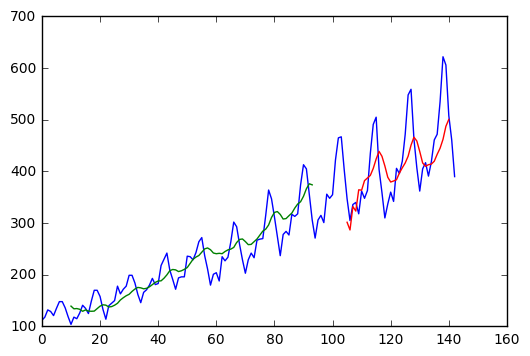

In [39]:
for i in tqdm.tqdm(range(20)):
    model.fit(trainX, 
              trainY, 
              nb_epoch=1, 
              batch_size=batch_size, 
              verbose=0, 
              shuffle=False)
    model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=2)
model.reset_states()
testPredict = model.predict(testX, batch_size=2)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-2, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [44]:
# Stacked GRU for international airline passengers problem

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import tqdm

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('files/international-airline-passengers.csv', 
                            usecols=[1], 
                            engine='python', 
                            skipfooter=3)
dataset = dataframe.values[:-1]
dataset = dataset.astype('float32')


# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset)-1,:]

# reshape 
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the GRU network
batch_size = 2
model = Sequential()
model.add(GRU(32, 
               batch_input_shape=(batch_size, look_back, 1),
               stateful=True, 
               return_sequences=True))
model.add(GRU(32, 
               stateful=True))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print trainX.shape, trainY.shape

for i in tqdm.tqdm(range(50)):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-2, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

(84, 10, 1) (84,)


100%|██████████| 50/50 [00:31<00:00,  1.88it/s]


Train Score: 15.68 RMSE
Test Score: 93.05 RMSE


## Power Consumption.

The task here will be to be able to predict values for a timeseries : the history of 2 million minutes of a household's power consumption. We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values. Put another way, given 49 timesteps of consumption, what will be the 50th value?

The initial file contains several different pieces of data. We will here focus on a single value : a house's Global_active_power history, minute by minute for almost 4 years. This means roughly 2 million points. 

Notes:

+ Neural networks usually learn way better when data is pre-processed. However regarding time-series we do not want the network to learn on data too far from the real world. So here we'll keep it simple and simply center the data to have a 0 mean.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import zipfile 

np.random.seed(1234)

def data_power_consumption(path_to_dataset,
                           sequence_length=50,
                           ratio=1.0):

    max_values = ratio * 2049280
    
    zfile = zipfile.ZipFile(path_to_dataset)
    zfile.extractall("files/")
    
    with open('files/household_power_consumption.txt') as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[2]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values >= max_values:
                break

    print("Data loaded from csv. Formatting...")

    result = []
    for index in range(len(power) - sequence_length):
        result.append(power[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean
    print("Shift : ", result_mean)
    print("Data  : ", result.shape)

    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]

global_start_time = time.time()
ratio = 0.5
sequence_length = 50
path_to_dataset = 'files/household_power_consumption.zip'


print('Loading data... ')
X_train, y_train, X_test, y_test = data_power_consumption(
            path_to_dataset, sequence_length, ratio)

print('\nData Loaded.')

Loading data... 
Data loaded from csv. Formatting...
('Shift : ', 1.1030964434554305)
('Data  : ', (1024590, 50))

Data Loaded.


In [9]:
X_train=X_train[:20000,:,:]
y_train=y_train[:20000]
X_test=X_test[:10000]
y_test=y_test[:10000]

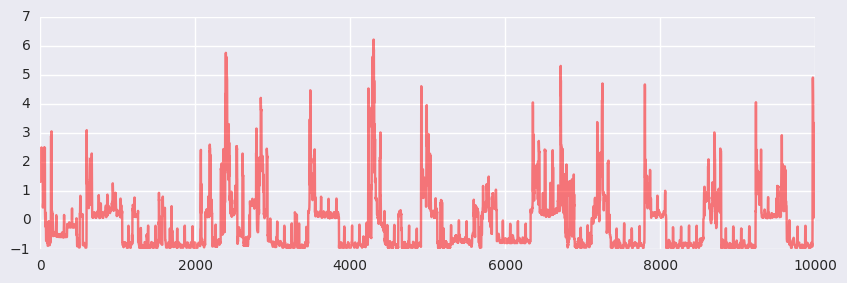

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, 'r', alpha=0.5)
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()

In [11]:
model = Sequential()
layers = [1, 50, 100, 1]

model.add(LSTM(
    input_dim=layers[0],
    output_dim=layers[1],
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    layers[2],
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=layers[3]))
model.add(Activation("linear"))

start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print "Compilation Time : ", time.time() - start

Compilation Time :  0.0306689739227


In [12]:
epochs = 1
model.fit(X_train, y_train,
          batch_size=10, 
          nb_epoch=epochs, 
          validation_split=0.05)
predicted = model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

Train on 19000 samples, validate on 1000 samples
Epoch 1/1
19000/19000 [==============================] - 203s - loss: 0.1503 - val_loss: 0.0872


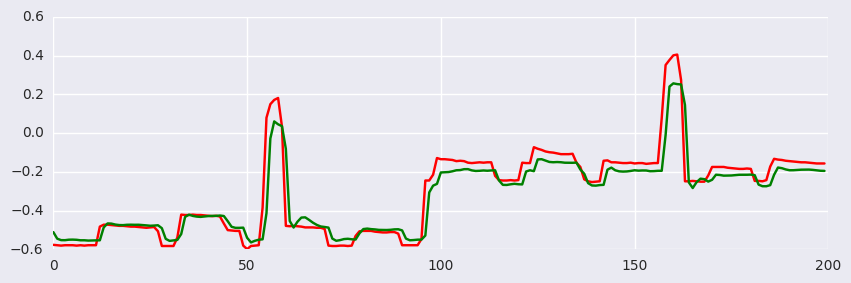

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test[250:450], 'r')
plt.plot(predicted[250:450], 'g')
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()

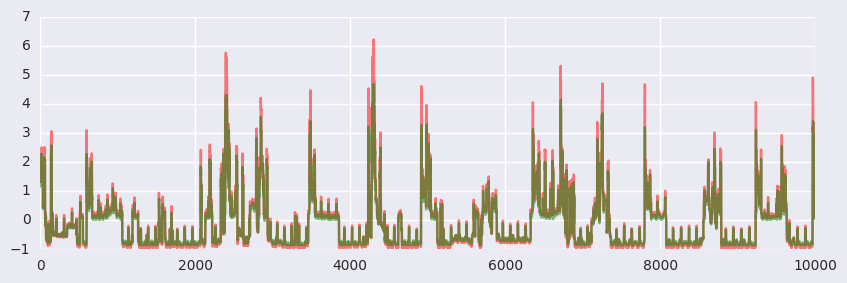

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, 'r', alpha=0.5)
plt.plot(predicted, 'g', alpha=0.5)
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()